In [1]:
import cv2
import numpy as np
import sys
import math
import matplotlib.pyplot as plt
sys.path.append("../")
%matplotlib inline

In [8]:
from vmarker import *
import pickle

In [11]:
cap = cv2.VideoCapture("Videos/square50.avi")

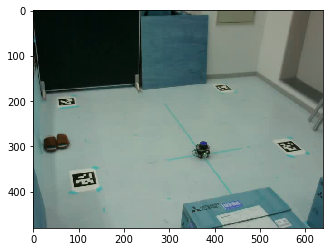

In [28]:
ok,frame = cap.read()
sframe = frame.copy()

plt.imshow(frame,cmap='gray')

In [5]:
K = np.loadtxt("../calib_usb/K.csv",delimiter=",")
dist_coef = np.loadtxt('../calib_usb/d.csv',delimiter=",")
vm = vmarker(markernum=5,K=K,dist=dist_coef,markerpos_file="roomA_ground_orig.csv")

4


In [46]:
fp= cv2.aruco.DetectorParameters_create()
fp.minDistanceToBorder

3

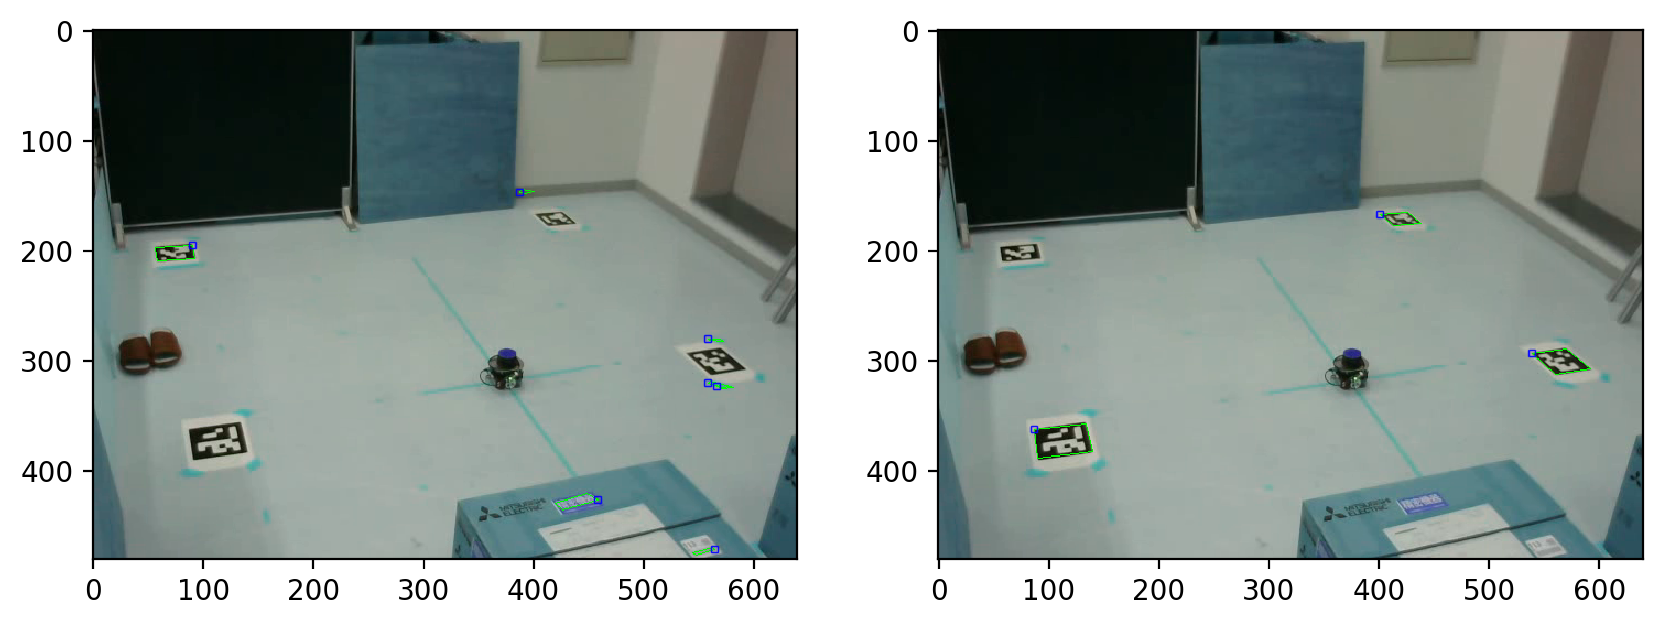

In [37]:
ok,frame = cap.read()
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(frame.copy(), vm.dictionary)
fig = plt.figure(figsize=(10,10),dpi=200)
plt.subplot(121)
plt.imshow(cv2.aruco.drawDetectedMarkers(frame.copy(),rejectedImgPoints))
plt.subplot(122)
plt.imshow(cv2.aruco.drawDetectedMarkers(frame.copy(),corners))


In [24]:
corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(sframe.copy(), vm.dictionary)

In [33]:
vm.objp

array([[-1.426, -1.088,  0.   ],
       [-1.412,  0.912,  0.   ],
       [ 0.088, -1.088,  0.   ],
       [ 0.088,  0.912,  0.   ]])

In [30]:
centercorners= []
geometrypositions = []
for id_,corner in sorted(zip(ids,corners)): #corner=[x11,y11]...
    centercorners.append(np.average(corner,1))
    geometrypositions.append(vm.objp[id_])

In [34]:
np.array(geometrypositions).reshape(len(ids),3)

array([[-1.426, -1.088,  0.   ],
       [-1.412,  0.912,  0.   ],
       [ 0.088, -1.088,  0.   ],
       [ 0.088,  0.912,  0.   ]])

In [18]:
tv = []
while tv == []:
    cv2.destroyAllWindows()
    ok,frame = cap.read()
    sframe = frame.copy()
    cv2.startWindowThread()
    tv=vm.getcamerapose(frame)
    cv2.waitKey(1)

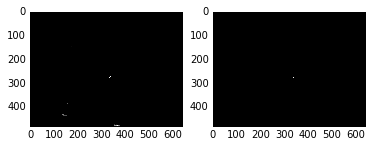

In [35]:
img = sframe

# HSV色空間に変換
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(1)
# 赤色のHSVの値域1
hsv_min = np.array([0,127,0])
hsv_max = np.array([10,255,255])
mask1 = cv2.inRange(hsv, hsv_min, hsv_max)
plt.subplot(121)
plt.imshow(mask1,cmap='gray')

# 赤色のHSVの値域2
hsv_min = np.array([150,127,0])
hsv_max = np.array([180,255,255])
mask2 = cv2.inRange(hsv, hsv_min, hsv_max)
plt.subplot(122)
plt.imshow(mask2,cmap='gray')


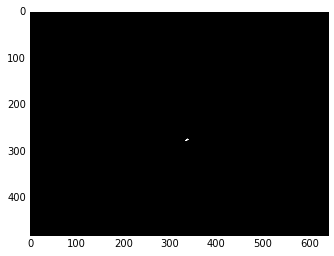

In [39]:
# RGB search
bgr_min = np.array([0,0,120])
bgr_max = np.array([50,50,255])
mask3 = cv2.inRange(img,bgr_min, bgr_max)
plt.imshow(mask3,cmap='gray')

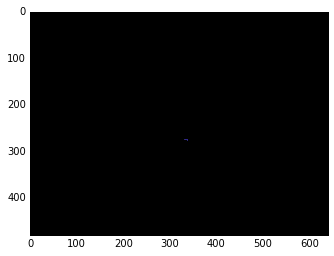

In [8]:
plt.imshow(cv2.bitwise_and(img,img,mask=mask2),cmap='gray')

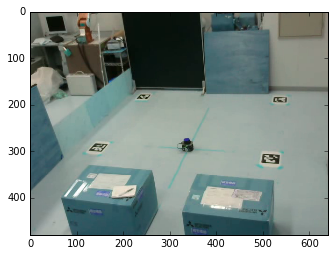

In [9]:
plt.imshow(sframe)

In [66]:
Mmt = cv2.moments(mask2)

In [71]:
# extract center of gravity
cx = Mmt['m10']/Mmt['m00']
cy = Mmt['m01']/Mmt['m00']
print([cx,cy])

[336.37931034482756, 275.17241379310343]


In [141]:
#vm.getobjpose_1([cx,cy],0.13)
vm.R,_ = cv2.Rodrigues(vm.rvecs)
pt = cv2.undistortPoints(np.array([cx,cy]).reshape(-1,1,2),vm.K,vm.dist,P=vm.K)
Rt = np.concatenate([vm.R,vm.tvecs],axis=1)
P = np.dot(K,Rt)


In [166]:
z = -0.13
A3 = - np.float32([pt[0,0,0],pt[0,0,1],1]).reshape(3,1) #A1,A2 = self.Rt[:,0],self.Rt[:,1] 
A4 = P[:,2:3]*z+P[:,3:4]

In [124]:
A3

array([[-336.37036133],
       [-275.15518188],
       [  -1.        ]], dtype=float32)

In [167]:
A = np.concatenate([P[:,0:2],A3,A4],axis=1)
U, S, V = np.linalg.svd(A) # use svd to get null space
vec = V[3]
X = vec[0]/ vec[3]
Y = vec[1]/ vec[3]
print([X,Y])
# zissai [1,1.5] ni +[0.088,-0.088]teido? [0.001,0.1]

[1.0890752595558166, 1.4249659515064161]


In [150]:
def showProj(pts):
    orig = P.dot(np.float32(pts).reshape(4,1))
    print(orig/orig[2])

In [151]:
showProj([X,Y,-0.13,1])

[[ 336.37035039]
 [ 275.15518466]
 [   1.        ]]


In [146]:
showProj([2,0,0,1])

[[ 536.33248554]
 [ 189.18650948]
 [   1.        ]]


In [152]:
# debug
#cv2.projectPoints(np.float32([2,0,0]).reshape(-1,1,3),vm.rvecs,vm.tvecs,vm.K,vm.dist)
#cv2.Rodrigues(vm.rvecs)

## Method2

In [158]:
plane2dmap = vm.objp[:,0:2].reshape(-1,1,2)

In [162]:
Homo,inliner = cv2.findHomography(vm.ccorners,plane2dmap,cv2.RANSAC,3.0)

In [168]:
posxy = cv2.perspectiveTransform(np.float32([cx,cy]).reshape(-1,1,2),Homo)
print(posxy[0,0])

[ 1.01489985  1.20405388]


In [176]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## time keisoku

In [10]:
def extractRed(img):
    # HSV色空間に変換
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 赤色のHSVの値域2
    hsv_min = np.array([150,127,0])
    hsv_max = np.array([179,255,255])
    mask2 = cv2.inRange(hsv, hsv_min, hsv_max)
    
    Mmt = cv2.moments(mask2)
    if Mmt["m00"] != 0:
        cx = Mmt['m10']/Mmt['m00']
        cy = Mmt['m01']/Mmt['m00']
    else:
        cx,cy = 0,0
    #print([cx,cy])
    return mask2,[cx,cy]

In [24]:
%time 500
mask,cpts = extractRed(sframe)
#cv2.imshow("mask",mask)
tv = vm.getcamerapose(sframe.copy())
if vm.PNPsolved:
    objxy = vm.getobjpose_1(cpts,-0.13)
    print([objxy[0] -1.088,objxy[1] -1.412])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 11.9 µs
[-0.0025631627336661911, 0.0071565923749046245]
